# Предобработка текста

Пусть нам необходимо решить задачу классификации текстов. Для того, чтобы извлекать признаки из текста, часто требуется его предварительно обработать. В этой главе мы рассмотрим техники ручной обработки текста с помощью библиотеки ```natasha```, а также регулярных выражений. Начнем с импорта всех необходимых библиотек.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re  # регулярные выражения
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # построение графиков
import seaborn as sns  # построение графиков

from tqdm import tqdm  # таймер
from collections import Counter
from nltk.corpus import stopwords  # список стоп-слов для разных языков (предлоги, местоимения)
from nltk.draw import dispersion_plot  # функция для отрисовки графика дисперсии
from nltk.stem.snowball import SnowballStemmer  # реализация алгоритма стемминга 
from natasha import (
    Segmenter,  # токенизация
    MorphVocab,  # определение части речи
    NewsMorphTagger,   
    NewsEmbedding,  
    Doc
)
from string import punctuation  # строка со знаками препинания: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
from sklearn.base import TransformerMixin

Инициализируем таймер, зададим стиль для красивой отрисовки графиков:

In [3]:
sns.set_theme()
tqdm.pandas()

Инициализируем необходимые компоненты для предобработки текста с помощью библиотеки natasha. Более подробно работа каждого компонента будет рассмотрена ниже.

In [4]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

stop_words = list(punctuation)
stop_words.extend(stopwords.words('russian'))

snow_stemmer = SnowballStemmer(language='russian')

Наконец, загрузим данные.

In [5]:
DATA_PATH = "data/train.csv"

In [6]:
df = pd.read_csv(DATA_PATH)
df.head()

,text,class
0,проблема: не открывается АКТ сверки по СБС № П...,1-46
1,В случае выбора неверного шаблона просьба указ...,1-70
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28


# Анализ датасета

В любой задаче машинного обучения важно понимать структуру и особенности данных, с которыми ведется работа. От этого напрямую зависит качество модели.

Проанализируем исходный набор данных. Он содержит две колонки: сообщение в поддержку и категорию, к которой оно относится. Всего в датасете 15449 строк и 77 категорий. В среднем на каждую категорию приходится по 200 запросов. Посмотрим на распределение сообщений по категориям. Для этого построим столбчатую диаграмму. По горизонтальной оси отложим категории. Высота столбца будет равна количеству объектов в наборе данных, относящихся к этой категории.

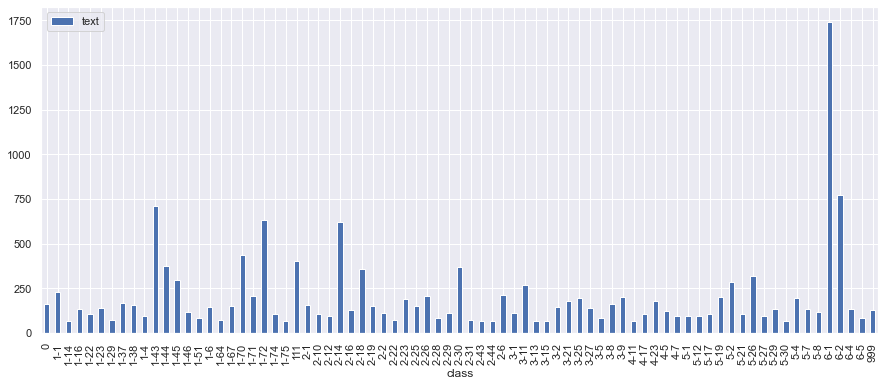

In [7]:
df.groupby('class').count().plot(kind='bar', figsize=(15, 6));

In [8]:
df.groupby('class').count().describe()

,text
count,77.000000
mean,200.636364
std,229.875304
min,64.000000
25%,95.000000
50%,136.000000
75%,202.000000
max,1738.000000


In [9]:
df.shape

(15449, 2)

In [10]:
df['class'].nunique()

77

Как мы видим из графика, набор данных не сбалансирован – в каждой категории разное число объектов с сильным разбросом по количеству сообщений. В категории *6-1* находится больше всего запросов (1738). В то же время минимальное число сообщений в категории – 64. Таким образом, может возникнуть проблема при распознавании сообщений, если в соответствующей группе мало данных. 

# Анализ текстов, относящихся к классу 6-1

Выберем из данных все тексты, относящиеся к классу *6-1*, и проанализируем их как отдельный корпус

In [11]:
x = df[df['class'] == '6-1']
x.head()

,text,class
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1
5,"Подскажите пожалуйста, какую Роль необходимо п...",6-1
8,Вопрос/Проблема: Добрый день! есть права на до...,6-1
34,"Добрый день в SAP УВХД, необходимо предоставит...",6-1
39,Вопрос/проблема: прошу дать консультацию какие...,6-1


### Токенизация, лемматизация, подсчет статистики по тексту

**Токенизация** – это процесс разбиения фразы, предложения, абзаца или всего текстового документа на более мелкие смысловые единицы, например, отдельные слова или термины. 

**Лемматизация** – это процесс поиска начальной формы слова. Он является важным этапом во многих задачах, связанных с обработкой естественных языков. Лемматизация минимизирует неоднозначность текста. Это помогает в подготовке признаков. Чем чище данные, тем интеллектуальнее и точнее будет модель машинного обучения. Лемматизация также экономит память и вычислительные затраты.

Предположим, в корпусе текстов нам встретились слова «работать» и «работающий». «Работающий» - это причастие, то есть, самостоятельная часть речи, которая обозначает признак предмета по действию. Оно образовано от глагола «работать», и цель лемматизации в данном случае – заменить причастие формой, от которого оно было образовано. 

Применив такое преобразование ко всему корпусу текстов можно добиться того, что все слова будут приведены к начальной форме. В этом случае упрощается задача определения самых часто встречающихся слов. 

**Стемминг** – это процесс удаления окончаний, суффиксов и приставок с целью получить основу слова. Как и лемматизация, он требуется для сокращения количества слов в словаре за счет объединения схожих по написанию и значению слов.  

Количество корректных словоформ, значения которых схожи, но написания отличаются суффиксами, приставками, окончаниями и прочим, очень велико, что усложняет создание словарей и дальнейшую обработку. Чтобы создать хорошо работающую модель, крайне важно отфильтровать незначительно отличающиеся по написанию и значению слова и преобразовать их в последовательные данные. Кроме того, это важная техника для получения данных строки из набора предложений и удаления избыточных данных.

Рассмотрим следующий пример. Пусть в тексте встретились слова «вопросом», «вопросами»,  «вопросов». До применения стемминга они будут считаться разными несмотря на то, что являются склонением одного и того же слова по падежам. Однако после применения преобразования останется основа «вопрос». Таким образом, мы значительно упрощаем задачу понимания текста для модели машинного обучения за счет понижения размерности пространства признаков.

Отличие стемминга от лемматизации в том, что конкретная реализация алгоритма стемминга действует без знания контекста и, соответственно, не понимает разницу между словами, которые имеют разный смысл в зависимости от части речи. Однако есть и свои преимущества: их проще внедрить, и они работают быстрее. 

Однако к применению стемминга нужно относиться с осторожностью. В отличие от лемматизации, это грубый процесс. При удалении окончаний, суффиксов и приставок есть вероятность, что различающиеся по смыслу слова сольются, так как будут иметь одинаковые основы.

В библиотеке ```natasha``` уже есть компоненты, которые могут токенизировать и лемматизировать текст. Для того, чтобы работать с текстом в этой библиотеке, нужно создать объект ```Doc```. В нем будет храниться вся информация, полученная в процессе предобработки другими компонентами этой библиотеки. Первым шагом в обработке текста является токенизация. ```Segmenter``` позволяет разделить текст на слова и предложения. Соответствующая информация будет храниться в атрибутах ```doc.tokens``` и ```doc.sents```.  

Перед тем, как перейти к лемматизации, требуется для каждого токена определить часть речи, к которой он относится. Как уже говорилось ранее, лемматизация - это процесс приведения слова к начальной форме. Определение части речи требуется для корректной работы алгоритма. Это можно сделать, используя компонент ```NewsMorphTagger```. 

Наконец, перейдем к лемматизации. Для этого воспользуемся методом ```lemmatize``` для каждого токена в тексте. В качестве параметра передадим объект ```MorphVocab```, который будет отвечать за преобразования текста.

Все эти шаги реализованы в функции ```preprocess```:

In [12]:
def preprocess(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)  

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    return doc

Обычно в тексте, помимо слов, содержится много других символов – знаков препинания, чисел, дат, имен собственных и т.д. Для человека это облегчает восприятие и понимание прочитанного, однако для моделей машинного обучения это представляет затруднения. Таким образом, любой текст необходимо подготовить – очистить от этих элементов. Также нужно учитывать, что, в отличие от человека, модель чувствительна к регистру: например, если для человека очевидно, что слова «данные», «Данные» и «ДаНныЕ» значат одно и то же, то модель не сможет этого понять. Поэтому все слова в тексте необходимо будет привести к одному регистру. 

Выше мы определили список стоп-слов: это предлоги, местоимения и знаки препинания. Очистим от них лемматизированный текст и приведем к одному регистру с помощью функции ```clean```. Также добавим сюда возможность не только лемматизации, но и стемминга, и сравним результаты:

In [13]:
def clean(doc, stopwords, stem=False):
    if stem:
        text = [
            snow_stemmer.stem(token.lemma.lower()) for token in doc.tokens 
            if snow_stemmer.stem(token.lemma.lower()) not in stopwords
        ]
    else:
        text = [
            token.lemma.lower() for token in doc.tokens if token.lemma.lower() not in stopwords
        ]

    return ' '.join(text)

Применим очистку текста к нашему корпусу. Так как операции предобработки текста могут занимать много времени, воспользуемся таймером (метод ```progress_apply```):

In [14]:
x['doc'] = x['text'].progress_apply(preprocess)
x['num_tokens'] = x['doc'].apply(lambda doc: len(doc.tokens))
x['num_sentences'] = x['doc'].apply(lambda doc: len(doc.sents))
x['cleaned'] = x['doc'].apply(lambda doc: clean(doc, stop_words))
x['stemmed'] = x['doc'].progress_apply(lambda doc: clean(doc, stop_words, stem=True))

  0%|          | 0/1738 [00:00<?, ?it/s]

100%|██████████| 1738/1738 [00:05<00:00, 332.57it/s]


Найдем статистику о корпусе текстов. Для этого нам необходимо составить словарь частотности каждого слова:

In [15]:
x['freq_dict'] = x['cleaned'].apply(lambda x: Counter(x.split(' ')))
x['freq_dict_stem'] = x['stemmed'].apply(lambda x: Counter(x.split(' ')))

Теперь найдем длину всего корпуса в токенах, предложениях, посчитаем число слов в словаре, среднюю длину слова и посчитаем коэффициент лексического разнообразия:

In [16]:
def text_stats(x):
    stats = pd.DataFrame(columns=['Значение'])
    freq_dict = x['freq_dict'].sum()

    stats.loc['Длина текста в токенах'] = x['num_tokens'].sum()
    stats.loc['Число предложений'] = x['num_sentences'].sum()
    stats.loc['Число слов в словаре'] = len(freq_dict.keys())
    stats.loc['Лексическое разнообразие'] = stats.loc['Число слов в словаре'] / stats.loc['Длина текста в токенах']
    stats.loc['Средняя длина слова'] = np.mean([len(word) for word in list(freq_dict.keys())])

    return stats

In [17]:
text_stats(x)

,Значение
Длина текста в токенах,64821.000000
Число предложений,4049.000000
Число слов в словаре,4805.000000
Лексическое разнообразие,0.074127
Средняя длина слова,7.722164


### Анализ стоп-слов

В любом языке есть слова, которые часто употребляются практически в каждом тексте. Это местоимения, частицы, предлоги, союзы, междометия. Для моделей машинного обучения они не несут большой смысловой нагрузки, а наоборот, усложняют выделение ключевых слов. Поэтому составляется список стоп-слов, которые потом необходимо удалить. 

Этот инструмент обладает гибкостью, так как помимо перечисленных частей речи, стоп-словами могут являться любые другие слова, которые очень часто встречаются в тексте или которые аналитик хотел бы исключить из рассмотрения. Их можно определить с помощью анализа словаря частотности.

Напишем функцию, которая будет строить график частот встречаемости N самых популярных слов в корпусе:

In [18]:
def freq_plot(freq_dict, n=None):
    plt.figure(figsize=(15, 7));
    if not n:
        n = len(freq_dict)

    most_common = freq_dict.most_common(n)
    plt.plot(
        [x[0] for x in most_common],     
        [x[1] for x in most_common]    
    );
    plt.xticks(rotation=90);

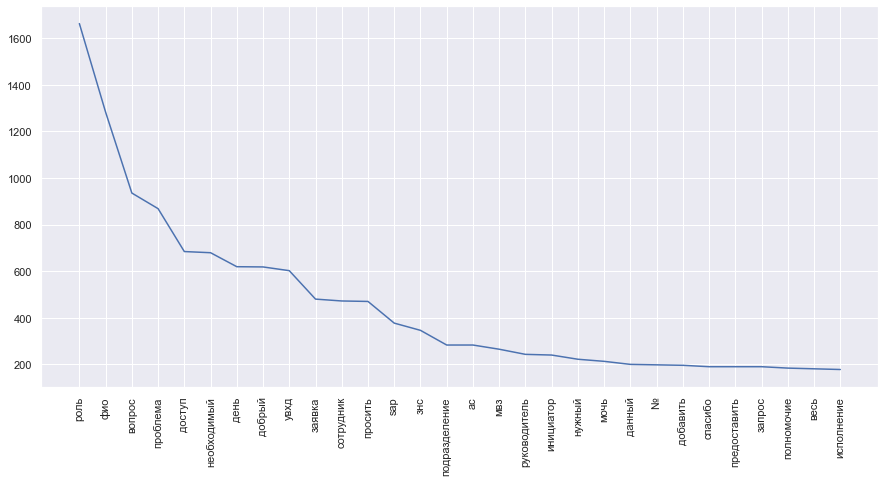

In [19]:
freq_dict = x['freq_dict'].sum()
freq_plot(freq_dict, 30)

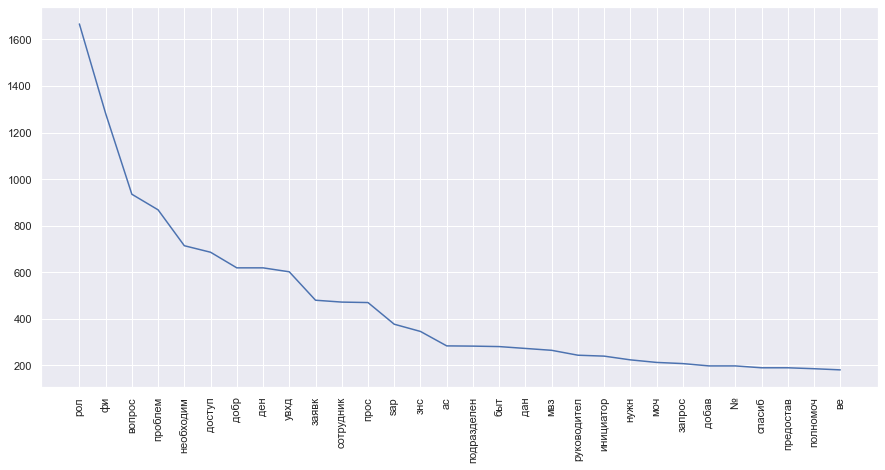

In [20]:
freq_dict_stem = x['freq_dict_stem'].sum()
freq_plot(freq_dict_stem, 30)

Из графика видно, что такие слова, как "роль", "фио", "вопрос", "проблема" встречаются во многих документах. Таким образом, мы можем добавить их в список стоп-слов, так как они не дают представления о тематике текстов и являются очень общими. Посмотрим, как изменится график частотности после их удаления.

In [21]:
stop_words.extend([
    'роль', 'фио', 'вопрос', 'проблема', 'добрый', 'день', '№',
    'рол', 'фи', 'проблем', 'добр', 'ден'
])
x['cleaned'] = x['doc'].apply(lambda doc: clean(doc, stop_words))
x['freq_dict'] = x['cleaned'].apply(lambda x: Counter(x.split(' ')))

x['stemmed'] = x['doc'].apply(lambda doc: clean(doc, stop_words, stem=True))
x['freq_dict_stem'] = x['stemmed'].apply(lambda x: Counter(x.split(' ')))

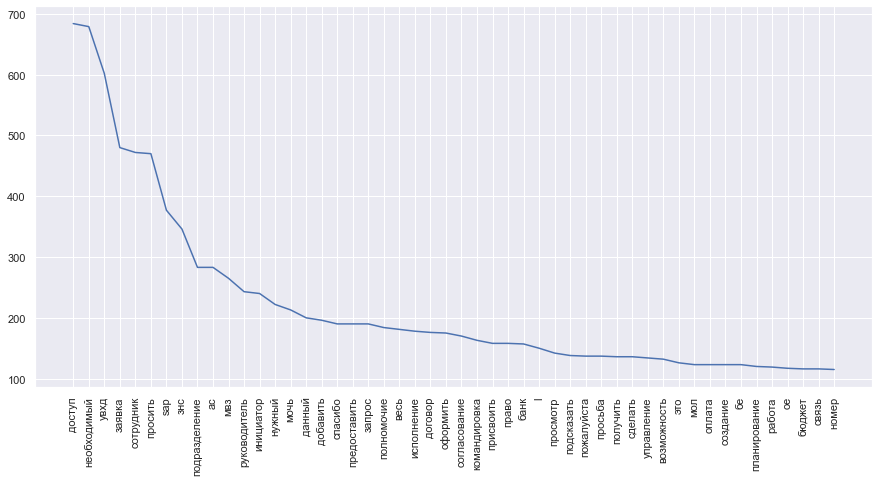

In [22]:
freq_dict = x['freq_dict'].sum()
freq_plot(freq_dict, 50)

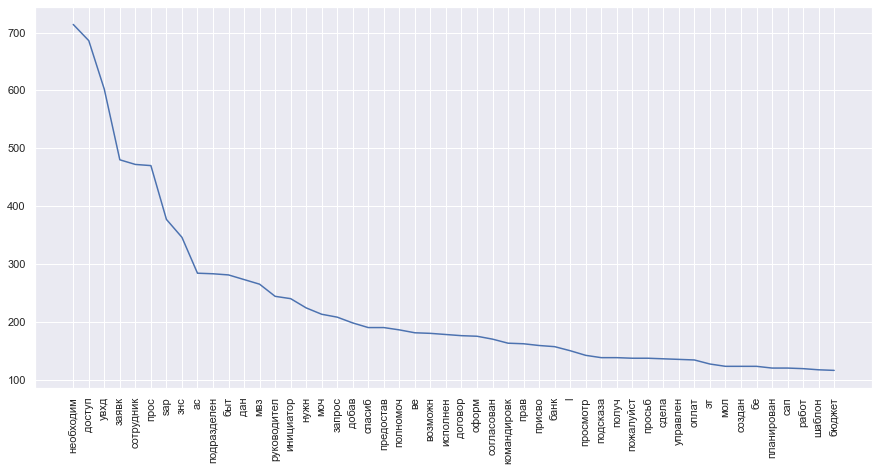

In [23]:
freq_dict_stem = x['freq_dict_stem'].sum()
freq_plot(freq_dict_stem, 50)

Видим, что теперь по наиболее часто встречающимся словам более понятна тематика текста. Однако здесь по-прежнему остаются общие слова, например, "спасибо", "пожалуйста", "просьба". Добавим их в список стоп-слов и посмотрим, как изменится график частотности.

In [24]:
stop_words.extend([
    'спасибо', 'просить', 'просьба', 'пожалуйста', 'сделать', 'это', 'мочь', 'мол', 'сап', 'sap',
    'прос', 'быт', 'дан', 'нужн', 'моч', 'спасиб', 'прав', 'пожалуйст', 'l', 'подсказа', 'просьб', 'сдела', 'эт'
])
x['cleaned'] = x['doc'].apply(lambda doc: clean(doc, stop_words))
x['freq_dict'] = x['cleaned'].apply(lambda x: Counter(x.split(' ')))

x['stemmed'] = x['doc'].apply(lambda doc: clean(doc, stop_words, stem=True))
x['freq_dict_stem'] = x['stemmed'].apply(lambda x: Counter(x.split(' ')))

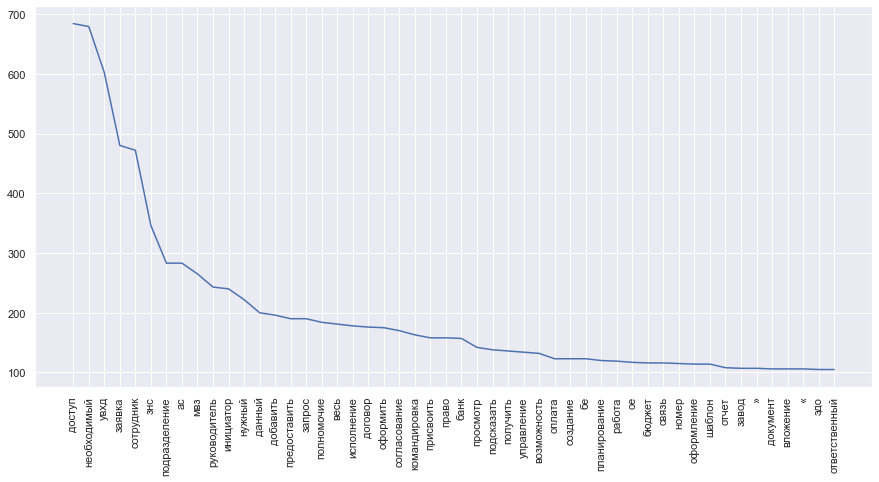

In [25]:
freq_dict = x['freq_dict'].sum()
freq_plot(freq_dict, 50)

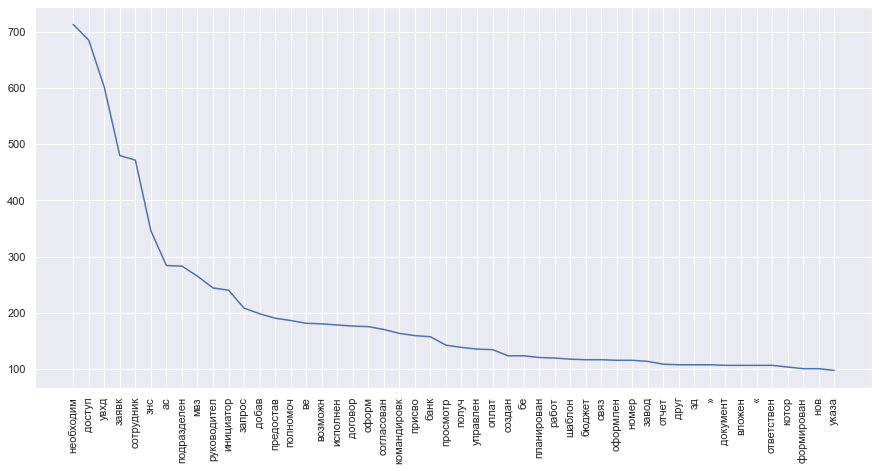

In [26]:
freq_dict_stem = x['freq_dict_stem'].sum()
freq_plot(freq_dict_stem, 50)

Сейчас список наиболее часто встречающихся слов выглядит информативно. Однако если в процессе обучения моделей машинного обучения выяснится, что какие-то из них влияют на точность модели, список стоп-слов можно расширить или, наоборот, сократить. 

Также можно рассмотреть самые короткие слова в словаре на случай, если пропустили некоторые знаки препинания или другие слова. С помощью найденных символов дополнительно расширим список стоп-слов.

In [27]:
short_words = set([
    word for word in freq_dict.keys() if len(word) < 2
])
short_words

{'',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'i',
 'k',
 'm',
 'n',
 'p',
 'q',
 'r',
 's',
 'u',
 'v',
 'z',
 '«',
 '»',
 'б',
 'г',
 'д',
 'е',
 'з',
 'л',
 'м',
 'н',
 'п',
 'р',
 'т',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'ы',
 'э',
 'ю',
 '–',
 '“',
 '”',
 '•',
 '…',
 '→'}

In [28]:
stop_words.extend(list(short_words))
x['cleaned'] = x['doc'].apply(lambda doc: clean(doc, stop_words))
x['freq_dict'] = x['cleaned'].apply(lambda x: Counter(x.split(' ')))

x['stemmed'] = x['doc'].apply(lambda doc: clean(doc, stop_words, stem=True))
x['freq_dict_stem'] = x['stemmed'].apply(lambda x: Counter(x.split(' ')))

### Поиск ключевых слов, график дисперсии. Регулярные выражения

Проверим гипотезу, что ключевые слова в тексте длиннее среднего. Проанализируем длину слов в словаре. Для этого построим график распределения средней длины.

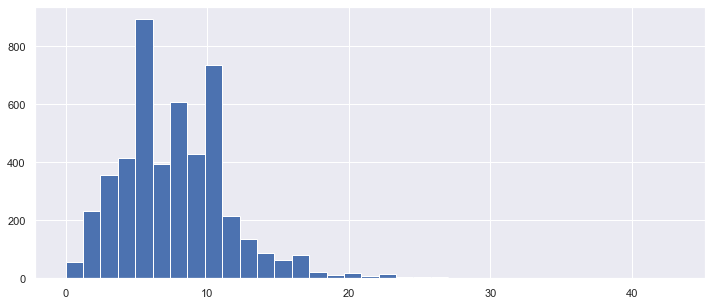

In [29]:
words_length = [len(word) for word in freq_dict.keys()]

plt.figure(figsize=(12, 5));
plt.hist(words_length, bins=35);

Предположим, что ключевые слова длиннее 20 букв. Посмотрим на эти слова поближе.

In [31]:
keywords = set([
    word for word in freq_dict.keys() if len(word) >= 20
])
keywords

{'124,128,130,133,135,161',
 '24866,24822,24365,24809',
 '5500-северо-западный',
 '6730,6740,6750,6760,6770',
 'hzhntonafiwfimydayzhyz-umoibiclgmdcaqowmbvx',
 'qirsimqlogmcfcvirjzevi',
 'wgpuycufkmxebstiizcaj',
 'zmm_batch_mov_report',
 'zrbs_reserv_transfer',
 'zre-bo-create-reports',
 'zre-bw-orggroup-0100',
 'zre-bw-orggroup-9900',
 'zron-reestr-on-spec-5200',
 'zroz-prosmotr-oi-zu-5200',
 'zrre-master-pfm-4400',
 'zrre-receive-change-categ-6712',
 'zrzu-reestr-zu-spec-5200',
 'zulo-dfw-invlblps-40',
 'zulo-dfw-rqsmng-16-1600',
 'zulo-dfw-spplmng-yy-nnnn',
 'zumm-dor-oe-70-10233413',
 'zumm-dor-oe-70-10236656',
 'zumm-dor-oe-70-10241081',
 'zumm-dor-oe-70-10259619',
 'zumm-dow-oe-13-10175873',
 'zumm-dow-oe-70-10259619',
 'zun_reestr_zdp-реестр',
 'zups-dow-mvz-16-1600',
 'zurc-dfw-dmsigner-yy',
 'zurc-dfw-iniznrs-yy-',
 'zurc-dfw-signereldockomd-55',
 'zurc-dmw-master-4200',
 'zurc-dmw-master-4400',
 'zurc-dmw-master-5200',
 'zurc-dmw-pmaster-10175079',
 'zurc-dmw-pmaster-10256132'

Видим, что в списке слов много мусора - слов на латинице, цифр и их комбинаций. Они будут негативно влиять на работу моделей, и их необходимо удалить. Сделать это можно с помощью регулярных выражений.

Регулярные выражения позволяют точно и гибко найти информацию в тексте, используя символы, слова или паттерны. Они пишутся, опираясь на следующие правила:
- ```^``` - начало строки
- ```$``` - конец строки
- ```.``` - любой символ
- ```\s``` - любой пустой символ (например, ' ', '\n', '\t')
- ```\S``` - любой не-пустой символ
- ```*``` - повторяет предыдущий символ 0 и более раз (жадная версия)
- ```*?``` - повторяет предыдущий символ 0 и более раз (нежадная версия)
- ```+``` - повторяет предыдущий символ 1 и более раз (жадная версия)
- ```+?``` - повторяет предыдущий символ 1 и более раз (нежадная версия)
- ```[aeiou]``` - любой символ из перечисленных
- ```[^XYZ]``` - любые символы, кроме перечисленных
- ```(``` - определяет, откуда начинать извлекать строку
- ```)``` - определяет, где заканчивать извлекать строку
- ```[a-z0-9]``` - перечисление символов может включать диапазон
- ```\w``` - эквивалент регулярного выражения [a-zA-Z0-9_]
- ```\d``` - выделение цифр (эквивалент [0-9])

Для отладки регулярных выражений можно использовать различные [сервисы](https://regex101.com/). 

Напишем регулярное выражение, которое будет выделять слова на латинице, которые могут содержать числа и знаки '_', '-', ','.

In [32]:
ENG_SYMBOLS_OR_DIGITS_REGEX = r'([a-zA-Z0-9]+_?-?,?)'

Удалим с помощью регулярного выражения найденный мусор и построим распределение длин слов заново. 

In [33]:
x['cleaned'] = x['cleaned'].apply(lambda text: re.sub(ENG_SYMBOLS_OR_DIGITS_REGEX, '', text))
x['stemmed'] = x['stemmed'].apply(lambda text: re.sub(ENG_SYMBOLS_OR_DIGITS_REGEX, '', text))
x['freq_dict'] = x['cleaned'].apply(lambda x: Counter(x.split(' ')))
x['freq_dict_stem'] = x['stemmed'].apply(lambda x: Counter(x.split(' ')))

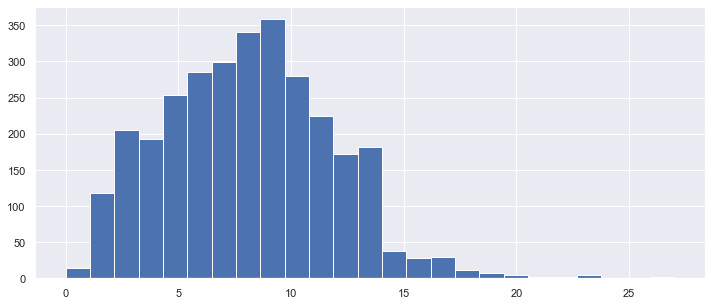

In [34]:
freq_dict = x['freq_dict'].sum()
words_length = [len(word) for word in freq_dict.keys()]

plt.figure(figsize=(12, 5));
plt.hist(words_length, bins=25);

Предположим, что ключевые слова длиннее 15 букв. Посмотрим на эти слова поближе.

In [35]:
keywords = set([
    word for word in freq_dict.keys() if len(word) >= 15
])
keywords

{'автоматизировать',
 'административный',
 'администрирование',
 'актуализированный',
 'актуализировать',
 'аналитик-эксперт',
 'бизнес-планирование',
 'благотворительность',
 'благотворительный',
 'верхнеуровневый',
 'вкладки-инициатор',
 'вложении-просить',
 'внутрибанковский',
 'внутрихозяйственный',
 'воспользоваться',
 'вышеперечисленный',
 'государственный',
 'дальневосточный',
 'делопроизводитель',
 'делопроизводителю',
 'делопроизводство',
 'директор-директор',
 'директора-начальника',
 'западно-сибирский',
 'западно-уральский',
 'зарегистрировать',
 'инвентаризационный',
 'исполнение-затрата',
 'калининград_рсцый',
 'кап-строительство',
 'квалифицированный',
 'клиенториентированость',
 'командироваться',
 'командировочный',
 'командировочными',
 'консолидированый',
 'консультацию-можно',
 'контролер-куратор',
 'корреспондентский',
 'материально-ответственный',
 'материально-технический',
 'межрегиональный',
 'месторасположение',
 'набережночелнинский',
 'недвижимость-план',
 '

Теперь построим график дисперсии 10 самых часто встречающихся ключевых слов в корпусе текстов:

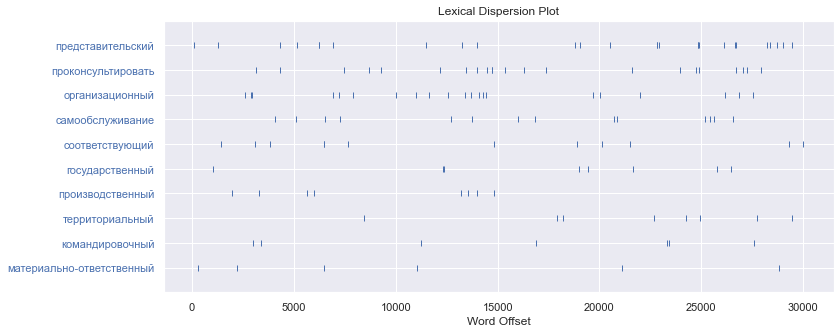

In [36]:
keywords_freq = Counter({word: count for word, count in freq_dict.items() if word in keywords})
text = ' '.join(x['cleaned'])

plt.figure(figsize=(12, 5));
dispersion_plot(
    text.split(' '), 
    [x[0] for x in keywords_freq.most_common(10)]
)

Проделаем аналогичные операции для предобработки текста со стеммингом:

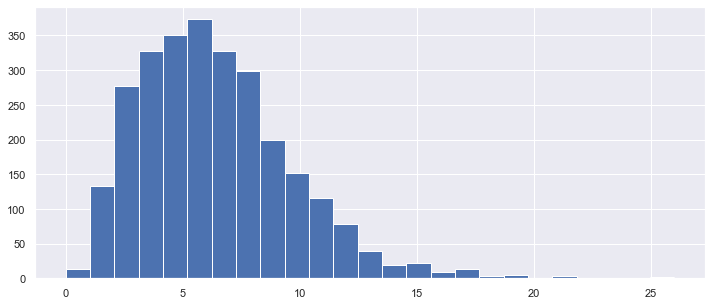

In [37]:
freq_dict_stem = x['freq_dict_stem'].sum()
words_length = [len(word) for word in freq_dict_stem.keys()]

plt.figure(figsize=(12, 5));
plt.hist(words_length, bins=25);

In [38]:
keywords_stem = set([
    word for word in freq_dict_stem.keys() if len(word) >= 12
])
keywords_stem

{'-руководител',
 'автоматизирова',
 'автоматическ',
 'автотранспорт',
 'административн',
 'администратор',
 'администрирован',
 'актуализирова',
 'александрович',
 'аналитик-эксперт',
 'андеррайтинг',
 'бизнес-планирован',
 'благосостоян',
 'благотворительн',
 'бюджетирован',
 'верхнеуровнев',
 'взаимодейств',
 'вкладки-инициатор',
 'владимирович',
 'вложении-прос',
 'внутрибанковск',
 'внутрихозяйствен',
 'вознагражден',
 'восстановлен',
 'вышеперечислен',
 'вячеславович',
 'государствен',
 'дальневосточн',
 'деблокирован',
 'делопроизводител',
 'делопроизводств',
 'директор-директор',
 'директора-начальник',
 'договора-центр',
 'дополнительн',
 'екатеринбург',
 'ж-амсс-сервис',
 'заархивирова',
 'западно-сибирск',
 'западно-уральск',
 'зарегистрирова',
 'заявкооборот',
 'злабел-введен',
 'зун_реестр_здп-реестр',
 'идентификатор',
 'инвентаризац',
 'инвентаризацион',
 'инкассаторск',
 'информирован',
 'инфраструктур',
 'исключительн',
 'исполнение-затрат',
 'исполнительн',
 'калининг

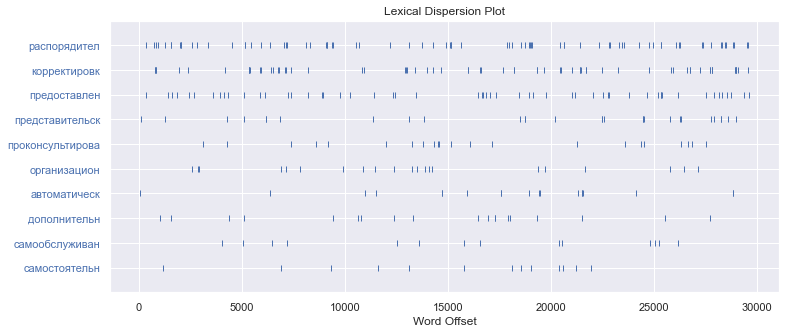

In [39]:
keywords_freq_stem = Counter({word: count for word, count in freq_dict_stem.items() if word in keywords_stem})
text = ' '.join(x['stemmed'])

plt.figure(figsize=(12, 5));
dispersion_plot(
    text.split(' '), 
    [x[0] for x in keywords_freq_stem.most_common(10)]
)

### sklearn pipelines

В следующих частях мы будем обучать модели из библиотеки sklearn. У этой библиотеки очень понятный и простой интерфейс. Рассмотрим некоторые принципы, в соответствии с которыми он построен.

1. Все объекты можно разделить на несколько видов: estimators, transformers и predictors. 
- **Оценщиком (estimator)** называется любой объект, который может проводить оценку параметров на основе набора данных. Оценка производится с помощью метода ```fit()```.
- **Трансформатором (transformer)** называется оценщик, который может преобразовывать набор данных. Трансформация выполняется методом ```transform()```.
- **Прогнозатором (predictor)** называется оценщик, который может делать прогнозы на основе набора данных с помощью метода ```predict()```.

2. Все блоки максимально возможно используются повторно и объединяются в композицию - **Pipeline**. Внутри композиции методы ```fit()``` и ```transform()``` выполняются последовательно для всех блоков через вызов специального метода ```fit_transform()```.

В случае, если требуется решить специфическую задачу, можно написать собственный трансформатор, чтобы обеспечить бесшовную работу с функциональностью sklearn. Напишем такой трансформатор, который будет содержать все шаги по обработке данных, рассмотренные выше. 
 

In [40]:
class TextTransformer(TransformerMixin):
     
    def __init__(self, stop_words, stem=False):
        self.stop_words = stop_words
        self.ENG_SYMBOLS_OR_DIGITS_REGEX = r'([a-zA-Z0-9]+_?-?,?)'
        self.stem = stem

    def _preprocess(self, text):
        doc = Doc(text)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)  

        for token in doc.tokens:
            token.lemmatize(morph_vocab)

        return doc

    def _clean(self, doc):
        if self.stem:
            text = [
                snow_stemmer.stem(token.lemma.lower()) for token in doc.tokens 
                if snow_stemmer.stem(token.lemma.lower()) not in stopwords
            ]
        else:
            text = [
                token.lemma.lower() for token in doc.tokens if token.lemma.lower() not in stopwords
            ]

        return ' '.join(text)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['doc'] = X['text'].progress_apply(self._preprocess)
        X['num_tokens'] = X['doc'].apply(lambda doc: len(doc.tokens))
        X['num_sentences'] = X['doc'].apply(lambda doc: len(doc.sents))
        X['cleaned'] = X['doc'].apply(
            self._clean
        ).apply(
            lambda text: re.sub(self.ENG_SYMBOLS_OR_DIGITS_REGEX, '', text)
        )
        return X

Для удобства использования все найденные стоп-слова можно сохранить в отдельный файл и использовать в дальнейшем.

In [41]:
with open('data/stop_words.txt', 'w', encoding='utf-8') as file:
    file.write('\n'.join(stop_words))

# Задание

1. Выберите датасет из предложенных вариантов:
- [Russian Social Media Text Classification](https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification)
- [Russian Sentiment Emotion Datasets](https://github.com/searayeah/russian-sentiment-emotion-datasets/tree/main)
- [RusAge: Corpus for Age-Based Text Classification](https://www.kaggle.com/datasets/oldaandozerskaya/fiction-corpus-for-agebased-text-classification)

2. Проведите анализ датасета:
- Постройте график распределения классов
- Найдите статистику по выбранному корпусу текстов
- Проведите токенизацию, лемматизацию, стемминг с помощью библиотеки ```natasha```
- Проведите очистку данных с помощью удаления стоп-слов и регулярных выражений
- Выделите ключевые слова и постройте график дисперсии

3. Полученные преобразования по токенизации и очистке текста представьте в виде sklearn pipeline.